# Least Squares

Alberto Quaini

### Import some libraries

In [168]:
import numpy as np
import cmath
from scipy import linalg as la
import matplotlib.pyplot as plt

## Problem 1

In [10]:
def solve_lin_sys(A, b):
    """ Solves Ax=b by decomposing A and solving Rx=Q^Tb
    where R is reduced upper triangular and Q reduced orthonormal
    """
    
    m, n = A.shape
    r = np.linalg.matrix_rank(A)
    if r < n:
        print("A is not full column rank")
    if not len(b) == m:
        print("dimensions of A and b are not compatible")
    
    Q, R = la.qr(A, mode='economic')
    x = la.solve_triangular(R, np.dot(Q.T, b))
    
    return x
    

In [11]:
A = np.random.random((5, 3))
b = np.random.random(5)
x = solve_lin_sys(A, b)
x

array([ 1.06019883, -0.09030601, -0.00468366])

In [24]:
normal_lhs = np.dot(np.dot(A.T, A), x)
normal_rhs = np.dot(A.T, b)
np.allclose(normal_lhs, normal_rhs)

True

## Problem 2

In [34]:
housing = np.load('housing.npy')
b = housing[:,1]
n = len(housing)
ones = np.ones(n)
A = np.column_stack((ones, housing[:,0]))

In [40]:
x = solve_lin_sys(A, b)

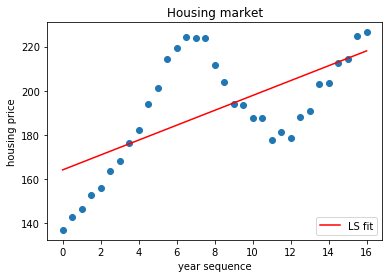

In [46]:
A2 = housing[:,0]
plt.scatter(A2, b)
plt.plot(A2, x[0] + x[1] * A2, 'r', label = "LS fit")
plt.xlabel('year sequence')
plt.ylabel('housing price')
plt.title('Housing market')
plt.legend(loc = 'lower right')
plt.show()

## Problem 3

In [47]:
x = la.lstsq(A, b)[0]

In [71]:
def ply_fit(A, b, d):
    """ Compute the polynomial (of degree d) fit of b based on A
    """
    
    vander = np.vander(A, d + 1)
    x = la.lstsq(vander, b)[0]
    
    
    return x, vander

In [73]:
x, vander = ply_fit(A2, b, 3)

In [74]:
x1 = np.polyfit(A2, b, 3)
x1

array([  0.15333253,  -4.13096835,  33.78211221, 116.92029369])

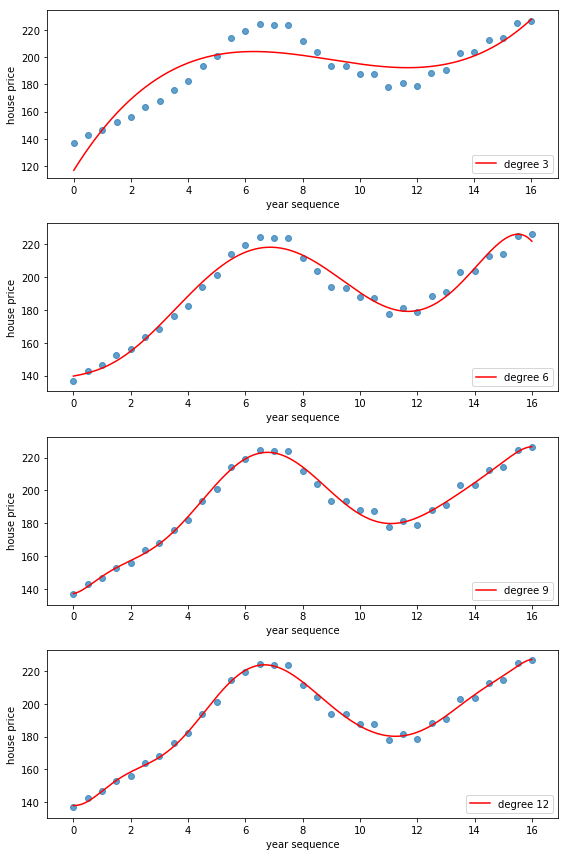

In [85]:
fig, axes = plt.subplots(4, 1, figsize = (8, 12))
grid = np.linspace(0, 16, 1_000)

for i, d in enumerate([3, 6, 9, 12]):
    x, vander = ply_fit(A2, b, d)
    bhat = np.vander(grid, d+1) @ x
    
    axes[i].plot(grid, bhat, 'r', label = 'degree {}'.format(d))
    axes[i].scatter(A2, b, alpha = .7)
    axes[i].legend(loc = 'lower right')
    axes[i].set_xlabel('year sequence')
    axes[i].set_ylabel('house price')
    plt.tight_layout()


## Problem 5

In [90]:
ellipse = np.load('ellipse.npy')

In [112]:
n = len(ellipse)
x = ellipse[:,0]
y = ellipse[:,1]
A = np.column_stack((x**2, x, x*y, y, y**2))
beta = la.lstsq(A, np.ones(n))[0]

In [134]:
def plot_ellipse(a, b, c, d, e):
    """Plot an ellipse of the form ax^2 + bx + cxy + dy + ey^2 = 1."""
    theta = np.linspace(0, 2*np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a*(cos_t**2) + c*cos_t*sin_t + e*(sin_t**2)
    B = b*cos_t + d*sin_t
    r = (-B + np.sqrt(B**2 + 4*A)) / (2*A)
    plt.plot(r*cos_t, r*sin_t, lw=2, color = 'r')
    plt.gca().set_aspect("equal", "datalim")

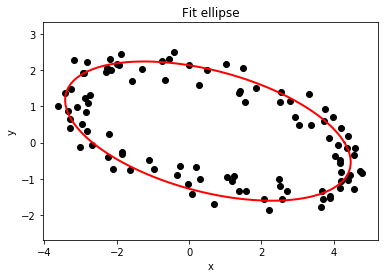

In [135]:
plt.scatter(x, y, color = 'black')
plot_ellipse(beta[0], beta[1], beta[2], beta[3], beta[4])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit ellipse')
plt.show()

## Problem 5

In [160]:
def power_mtd(A, N, tol):
    
    m, n = A.shape
    if not n == m:
        print("A is not square")
    
    x_old = np.random.random(n)
    x_old = x_old / la.norm(x_old)
    dist = tol + 1
    k = 1
    while (k < N) and (dist > tol):
        x_new = A @ x_old
        x_new = x_new / la.norm(x_new)
        dist = la.norm(x_new - x_old)
        x_old = x_new
        k += 1
    
    return (x_new.T @ A) @ x_new, x_new

In [161]:
A = np.random.random((10,10))
eigs, vecs = power_mtd(A, 100_000, 1e-8)
eigs1, vecs1 = la.eig(A)

In [162]:
eigs

4.636922516962386

In [166]:
eigs1.max()

(4.63692251714168+0j)

In [167]:
np.allclose(A @ vecs, eigs * vecs)

True

## Problem 6

In [188]:
def hess_precon(A, N, tol):
    
    m, n = A.shape
    if not n == m:
        print("A is not square")
    
    S = la.hessenberg(A)
    
    for k in range(N):
        Q, R = la.qr(S)
        S = R @ Q
    eigs = []
    i = 0
    
    while i < n:
        if (i<n-1 and abs(S[i+1,i]) < tol) or (i == n-1):
            eigs.append(S[i,i])
        else:
            eigs.append(S[i, i] + 
                        S[i+1, i+1] + 
                        cmath.sqrt((S[i,i] + S[i+1, i+1])**2 - 
                                   4 * (S[i, i+1] * S[i+1, 1])))/2
            eigs.append(S[i, i] + 
                        S[i+1, i+1] - 
                        cmath.sqrt((S[i, i] + S[i+1, i+1])**2 - 
                                   4 * (S[i, i+1] * S[i + 1, 1])))/2
            i += 1
        i += 1
    
    return eigs

In [189]:
A = np.random.random((4, 4))
AAT = A @ A.T

In [190]:
hess_precon(AAT, 100_000, 1e-8)

[3.920575310356262,
 0.5697255769266009,
 0.1971804291794045,
 0.11288056444000784]

In [191]:
la.eig(AAT)[0]

array([3.92057531+0.j, 0.56972558+0.j, 0.11288056+0.j, 0.19718043+0.j])